### Import and data filtering from Open fact Food Database

Open Food Facts is a food products database made by everyone, for everyone.
You can use it to make better food choices, and as it is open data, anyone can re-use it for any purpose.
more information can be find on the web site: https://fr.openfoodfacts.org/ and blog: https://en.wiki.openfoodfacts.org/Main_Page  
Database grow and product update: 
![alt text](https://fr.blog.openfoodfacts.org/images/products_20180327.png")  
Source of the actual (2016-2017) [data](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip)  
Update can be find [here](https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv) 

In [23]:
import pandas as pd

# import data
file_name = "fr.openfoodfacts.org.products.csv"
df = pd.read_csv(file_name, sep = "\t", header = 0, low_memory=False)

# select data for France 
mask = df["countries_fr"].str.contains("France", na = False)
df = df[mask];

In [24]:
print("shape: ", df.shape)

shape:  (98440, 162)


### Features Selection

C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Series.data is deprecated and will be removed in a future version
  


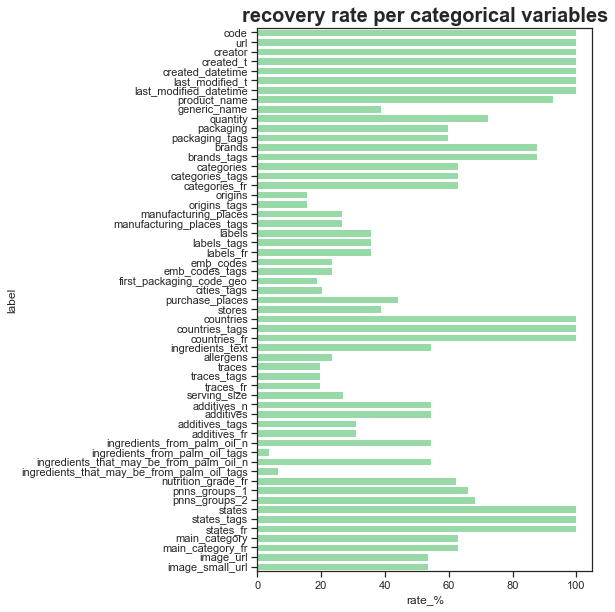

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# recovery rate per feature
sub_df = df.loc[:,"code":"image_small_url"]
buff = 100 - sub_df.isnull().sum()/len(sub_df) * 100
recovery = pd.DataFrame({"label": buff.index,
                         "rate_%" : buff.data})

cap = 0.1  # cap to define "marginal features" where recovery rate is below 0.1% --> to discuss with the customer
mask = (recovery["rate_%"] < cap)

sns.set(style="ticks", palette="pastel")

# plot
plt.figure(figsize=(6,10))
plt.title("recovery rate per categorical variables", fontweight="bold", size = 20)
sns.barplot(x= "rate_%", y= "label", data=recovery[~mask],  # ~mask: remove marginal features
            label="Total", color="g");

C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be removed in a future version
  """


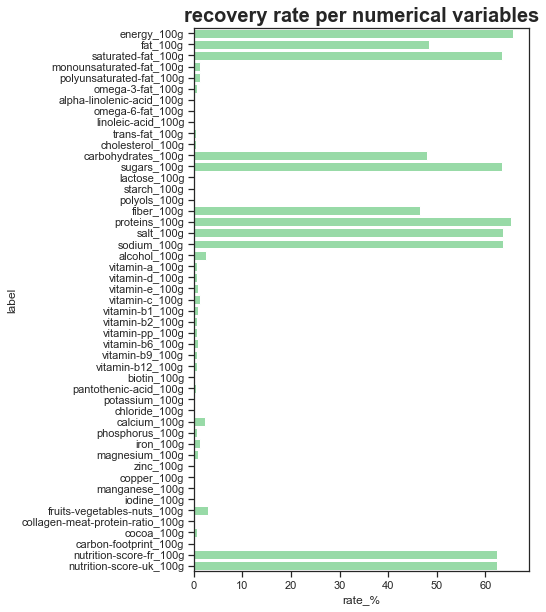

In [26]:
# recovery rate per feature for numerical features
sub_df = df.loc[:,"energy_100g":]
buff = 100 - sub_df.isnull().sum()/len(sub_df) * 100
recovery_100g = pd.DataFrame({"label": buff.index,
                         "rate_%" : buff.data})

cap = 0.1  # cap to define "marginal features" where recovery rate is below 0.1% --> to discuss with the customer
mask_100g = (recovery_100g["rate_%"] < cap)

sns.set(style="ticks", palette="pastel")

# Initialize the matplotlib figure
plt.figure(figsize=(6,10))
plt.title("recovery rate per numerical variables", fontweight="bold", size = 20)

# Plot of the recovery rate per feature
sns.barplot(x= "rate_%", y= "label", data=recovery_100g[~mask_100g],  # ~mask: remove marginal features
            label="Total", color="g");

In [27]:
# remove empty features (and almost empty)
recovery = pd.concat([recovery, recovery_100g])
mask = pd.concat([mask, mask_100g])
empty_feature = recovery.loc[mask, "label"]
print("Number of feature removed {}:\n{}".format(len(empty_feature),empty_feature))  
df = df.drop(columns = list(empty_feature))

Number of feature removed 56:
27                                   cities
36                             allergens_fr
41                            no_nutriments
47                ingredients_from_palm_oil
50    ingredients_that_may_be_from_palm_oil
52                       nutrition_grade_uk
1                      energy-from-fat_100g
4                         butyric-acid_100g
5                         caproic-acid_100g
6                        caprylic-acid_100g
7                          capric-acid_100g
8                          lauric-acid_100g
9                        myristic-acid_100g
10                       palmitic-acid_100g
11                        stearic-acid_100g
12                      arachidic-acid_100g
13                        behenic-acid_100g
14                     lignoceric-acid_100g
15                        cerotic-acid_100g
16                       montanic-acid_100g
17                       melissic-acid_100g
22               eicosapentaenoic-acid_100g
23

In [28]:
# selection of meaningfull and relatively complet features
# source: https://www.fourchette-et-bikini.fr/cuisine/nutrition/les-regles-de-base-de-la-dietetique-28750.html
selected_feature = ["code",
                    "url",
                    "product_name",
                    "brands",
                    "categories_fr",
                    "countries_fr",
                    "ingredients_text",
                    "ingredients_from_palm_oil_n",
                    "additives_fr",
                    "main_category_fr",
                    "nutrition_grade_fr"]

# we keep all the _100g feature left after the recovery rate filtering
feature_100g = df.loc[:,"energy_100g":].columns.values
selected_feature = selected_feature + list(feature_100g)
df = df[selected_feature]

### Products selection

In [29]:
# look for duplicate products ("code" feature)
max_count = df["code"].value_counts().max()
if max_count == 1:
    print("no double 'code' found")
else:
    print("!! Warning: duplicate values in code feature !!")

no double 'code' found


In [31]:
# look for outliers (check if max is above 100 or min < 0)
x = df.describe().T.round(1)[["min","max"]]
mask_max = x["max"] > 100
mask_min = x["min"] < 0
mask = (mask_max | mask_min)
x[mask]

,min,max
energy_100g,0.0,3251373.0
fat_100g,0.0,380.0
saturated-fat_100g,0.0,210.0
carbohydrates_100g,0.0,190.0
sugars_100g,-0.1,105.0
fiber_100g,0.0,178.0
salt_100g,0.0,211.0
vitamin-b1_100g,0.0,161.0
carbon-footprint_100g,0.0,2520.0
nutrition-score-fr_100g,-15.0,40.0


In [32]:
# remove / remplace data where weight is above 110g or below 0 
# 10% margin because fluids/semi-fluids information are sometime stated for 100ml 
feature_100g = df.loc[:,"fat_100g":"cocoa_100g"].columns.values
df_100g = df.loc[:,feature_100g]  # buffer df for next operations
mask = ((df_100g > 110) | (df_100g < 0))
df_100g[mask] = None
df.loc[:,feature_100g] = df_100g
del df_100g
print("{} values of nutritional elements (*_100g) considered as outlier and set to 'None' ({}%)".format((mask).values.sum(),
                                                                                    round((mask).values.sum()/len(df)*100,3)))


10 values of nutritional elements (*_100g) considered as outlier and set to 'None' (0.01%)


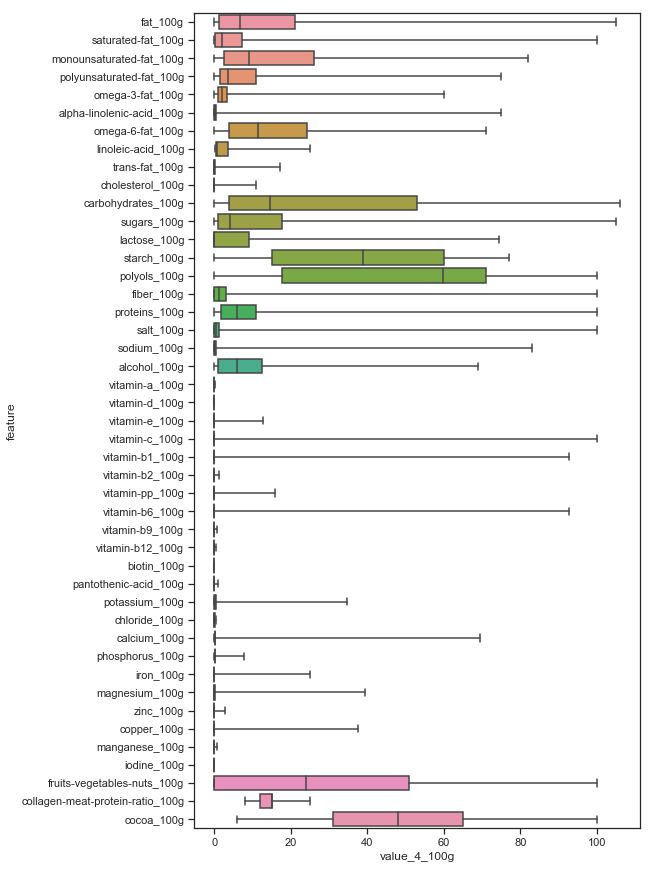

In [33]:
# Check distribution
# melt df for boxplot
df_melt = df.loc[:,feature_100g].melt(var_name= "feature", value_name="value_4_100g")
plt.figure(figsize=(8,15))
sns.boxplot(x="value_4_100g", y="feature", data=df_melt,
            whis="range")

In [34]:
# Check total weight
# total weight(100g) should be above the sum of the main sub composants
# main composants includes fat, carbohydrates , proteins and salt

# new variable Check_weight: sum of main nutriments (macronutriments) weights
macronutriments = ["fat_100g", "carbohydrates_100g", "fiber_100g", "proteins_100g", "salt_100g"]                       
df["check_weight"] = df.loc[:,macronutriments].sum(axis=1)

# filtering and line removal for total weight above 110g
mask = df["check_weight"] < 110

# personal note: () need for priority in (~x).sum()
print("{} products removed for incoherent weight ({}%)".format((~mask).sum(),
                                                               round((~mask).sum()/len(df)*100,3)))  

df = df[mask]

69 products removed for incoherent weight (0.07%)


In [35]:
# Check_weight: Fat
# Total fat includes saturated, polyunsaturated, monounsaturated, and trans fat.
# source: https://www.healthlinkbc.ca/health-topics/aa160619
fats = ["saturated-fat_100g", 
        "monounsaturated-fat_100g", 
        "polyunsaturated-fat_100g",
        "trans-fat_100g"] 
fats_tot_weight = df.loc[:,fats].sum(axis=1)
mask = fats_tot_weight > 1.1*df["fat_100g"]      # 1.1 for 10% margin
print("{}'fat_100g' values set to 'None' for incoherent in fat weight ({}%)".format((mask).sum(),
                                                                                    round((mask).sum()/len(df)*100,3)))
df.fat_100g[mask] = None

89'fat_100g' values set to 'None' for incoherent in fat weight (0.09%)


In [36]:
# Check_weight: Carbohydrates
# Total fat includes Sugars, Starches, Fibers, and Oligosaccharides (Not present).
# source: https://www.verywellfit.com/carbohydrates-2242004
carbohydrates = ["sugars_100g", "starch_100g", "fiber_100g"] 
carbohy_tot_weight = df.loc[:,carbohydrates].sum(axis=1)
mask = carbohy_tot_weight > 1.1*df["carbohydrates_100g"]   # 1.1 for 10% margin

print("{} 'carbohydrates_100g' values set to 'None' for incoherent in carbohydrates weight ({}%)".format((mask).sum(),
                                                                                    round((mask).sum()/len(df)*100,3)))
df.carbohydrates_100g[mask] = None

3758 'carbohydrates_100g' values set to 'None' for incoherent in carbohydrates weight (3.82%)


In [37]:
# we will use the nutrition-score-fr_100g as an indicator for completness of product information
# (cannot be computed otherwise)
b = df["nutrition-score-fr_100g"].isna().sum() /df["nutrition-score-fr_100g"].size * 100
mask = df["nutrition-score-fr_100g"].isna()
print("{} products removed for NaN in nutrition-score-fr_100g ({}%)".format(mask.sum(),
                                                                            round(mask.sum()/len(df)*100,3)))
df = df[~mask]

37020 products removed for NaN in nutrition-score-fr_100g (37.633%)


Information about energy content in food:
+ 1 gram of protein  =17 kJ  
+ 1 gram of fat = 37 kJ  
+ 1 gram of carbohydrates = 17 kJ  
+ 1 gram of dietary fibre = 8 kJ  
+ 1 gram of alcohol=  29 kJ  
Source: http://www.mydailyintake.net/calculating-energy/  
Assuming the most calorific food (100% fat), the maximum ammount should be around 37*100 = 3700 Kj. 

In [38]:
# filter energy outliers
limit = 3700    # Kj
mask = df["energy_100g"] > limit
count_ = mask.sum()
df.loc[mask,["energy_100g"]] = None     
print("{} outliers (>{}Kj) of 'energy_100g' set to 'None' ({}%)".format(count_, limit, round(count_/mask.size,3)))

246 outliers (>3700Kj) of 'energy_100g' set to 'None' (0.004%)


In [39]:
# filter product without name ("product_name")
count_ = df["product_name"].isna().sum()
df["product_name"].dropna()
print("{} products have been removed because of the 'product name' missing ({}% )".format(count_, round(count_/len(df),3)))

343 products have been removed because of the 'product name' missing (0.006% )


### Formating

In [40]:
# to avoid futur search issue we will pas all categorical feature in lowercase
selected_feature = ["url",
                    "product_name",
                    "brands",
                    "categories_fr",
                    "countries_fr",
                    "ingredients_text",
                    "additives_fr",
                    "main_category_fr",
                    "nutrition_grade_fr"]

df[selected_feature] = df[selected_feature].apply(lambda x: x.str.lower())

In [41]:
# rename energy_100g to energy_kj_100g for more clarity
df = df.rename(columns={'energy_100g': 'energy_kj_100g'})

# add energy_kcal_100g feature (E(kcal) = E(kJ) / 4.184)
df["energy_kcal_100g"] = df["energy_kj_100g"]/4.184

In [42]:
# new feature energy "manually" computed
df["check_energy_kj_100g"] = (17*df["proteins_100g"] 
                              + 37*df["fat_100g"] 
                              + 17*df["carbohydrates_100g"] 
                              + 8*df["fiber_100g"]) 
                              # alcohol ignored because of the poor recovery rate

### Save

In [21]:
# save processed dataframe
output_file_name = "processed_" + file_name
df.to_csv(output_file_name)